# Warehouse Inventory & Demand Analysis

This notebook presents an exploratory analysis of warehouse inventory and demand data
to identify stockout risks and improvement opportunities.



# 1. Introduction

The objective of this analysis is to examine inventory behavior and demand patterns
in a warehouse environment in order to identify stockout risks and improvement opportunities.



# 2. Data Loading

The dataset used in this analysis is loaded from a CSV file containing daily demand,
inventory levels, and replenishment lead time information for multiple SKUs.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.random.seed(42)

dates = pd.date_range(start="2024-01-01", periods=120)
skus = ["SKU_A", "SKU_B", "SKU_C"]

rows = []
for sku in skus:
    inventory = 500
    for date in dates:
        demand = np.random.poisson(lam=20)
        inventory -= demand
        stockout = 1 if inventory < 0 else 0
        inventory = max(inventory, 0)
        lead_time = np.random.randint(3, 10)

        rows.append([date, sku, demand, inventory, stockout, lead_time])

df = pd.DataFrame(
    rows,
    columns=["date", "sku", "demand", "inventory_level", "stockout", "lead_time_days"]
)

df.head()

,date,sku,demand,inventory_level,stockout,lead_time_days
0,2024-01-01,SKU_A,23,477,0,9
1,2024-01-02,SKU_A,19,458,0,5
2,2024-01-03,SKU_A,26,432,0,5
3,2024-01-04,SKU_A,25,407,0,6
4,2024-01-05,SKU_A,15,392,0,8


In [3]:
df.to_csv("../data/inventory_data.csv", index=False)
print("Saved to: InventoryAnalysis/data/inventory_data.csv")


Saved to: InventoryAnalysis/data/inventory_data.csv


In [4]:
df = pd.read_csv("../data/inventory_data.csv")
df.head()

,date,sku,demand,inventory_level,stockout,lead_time_days
0,2024-01-01,SKU_A,23,477,0,9
1,2024-01-02,SKU_A,19,458,0,5
2,2024-01-03,SKU_A,26,432,0,5
3,2024-01-04,SKU_A,25,407,0,6
4,2024-01-05,SKU_A,15,392,0,8


# 3. Data Cleaning

The dataset is checked for missing values and data consistency before proceeding with the analysis.

In [5]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             360 non-null    object
 1   sku              360 non-null    object
 2   demand           360 non-null    int64 
 3   inventory_level  360 non-null    int64 
 4   stockout         360 non-null    int64 
 5   lead_time_days   360 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 17.0+ KB


date               0
sku                0
demand             0
inventory_level    0
stockout           0
lead_time_days     0
dtype: int64

No missing values were detected, and all variables have appropriate data types.
The dataset is suitable for exploratory analysis.


# 4. Exploratory Data Analysis (EDA)

This section explores demand patterns and variability across different SKUs to understand consumption behavior and inventory risk.

In [6]:
df.groupby("sku")["demand"].describe()


,count,mean,std,min,25%,50%,75%,max
sku,,,,,,,,
SKU_A,120.0,20.158333,4.170718,10.0,17.0,19.5,23.00,32.0
SKU_B,120.0,19.566667,4.414897,9.0,16.0,20.0,22.25,30.0
SKU_C,120.0,20.008333,4.257462,10.0,17.0,20.0,23.00,31.0


In [7]:
demand_variability = df.groupby("sku")["demand"].std()
demand_variability


sku
SKU_A    4.170718
SKU_B    4.414897
SKU_C    4.257462
Name: demand, dtype: float64

Demand variability differs across SKUs, indicating that some products require
higher safety stock levels to prevent stockouts.


# 5. Inventory KPIs

This section calculates key inventory performance indicators used to
evaluate stock availability and inventory efficiency.


In [8]:
stockout_rate = (df.groupby("sku")["stockout"].mean() * 100).round(2)
stockout_rate


sku
SKU_A    80.00
SKU_B    78.33
SKU_C    80.00
Name: stockout, dtype: float64

Stockout rate represents the percentage of days when inventory was depleted.
Higher values indicate increased risk of service level failures.


In [9]:
avg_inventory = df.groupby("sku")["inventory_level"].mean().round(0)
avg_inventory


sku
SKU_A    50.0
SKU_B    52.0
SKU_C    50.0
Name: inventory_level, dtype: float64

Average inventory level indicates typical stock on hand and helps identify
potential overstocking or understocking situations.


# 6. Visualization

This section visualizes inventory level trends over time to highlight stock depletion patterns for each SKU.


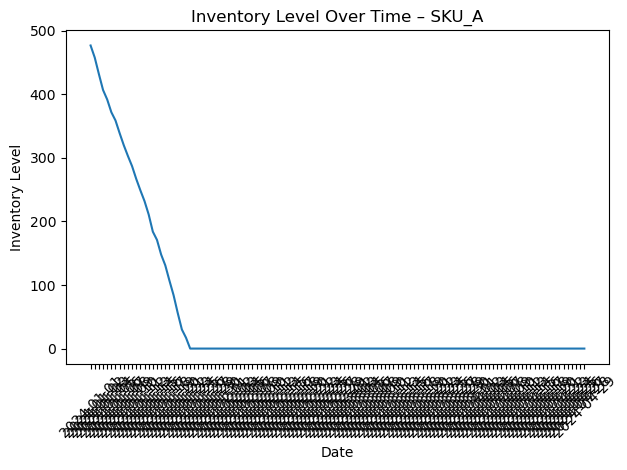

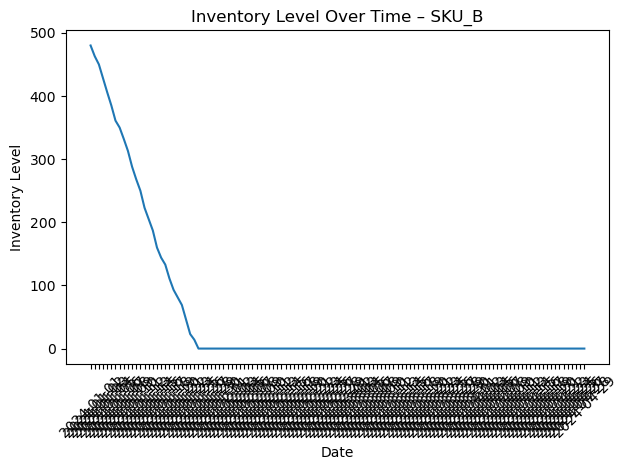

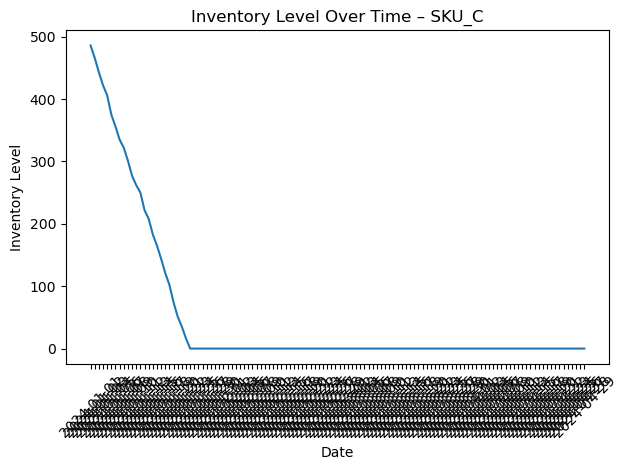

In [10]:
for sku in df["sku"].unique():
    sku_data = df[df["sku"] == sku]
    plt.figure()
    plt.plot(sku_data["date"], sku_data["inventory_level"])
    plt.title(f"Inventory Level Over Time – {sku}")
    plt.xlabel("Date")
    plt.ylabel("Inventory Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


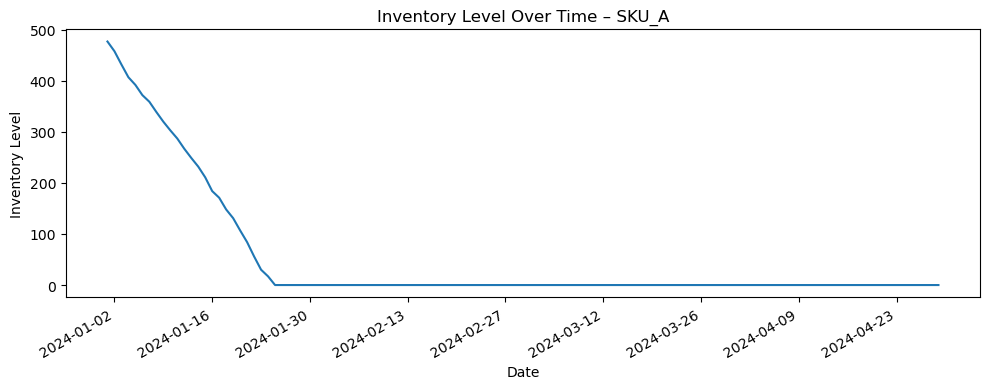

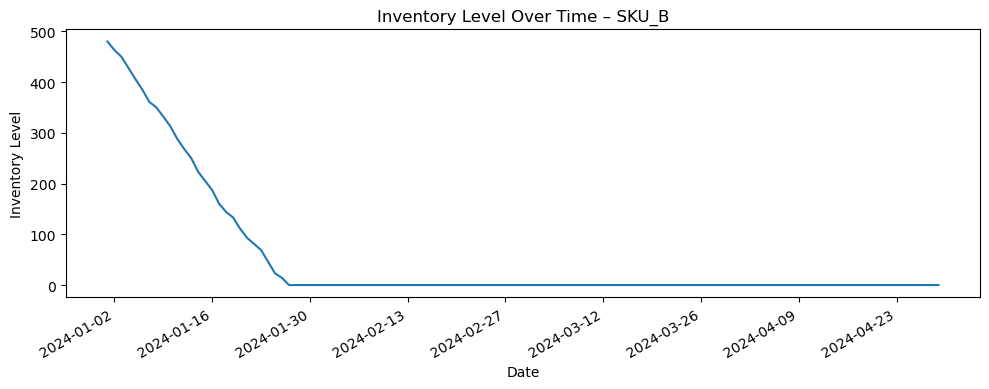

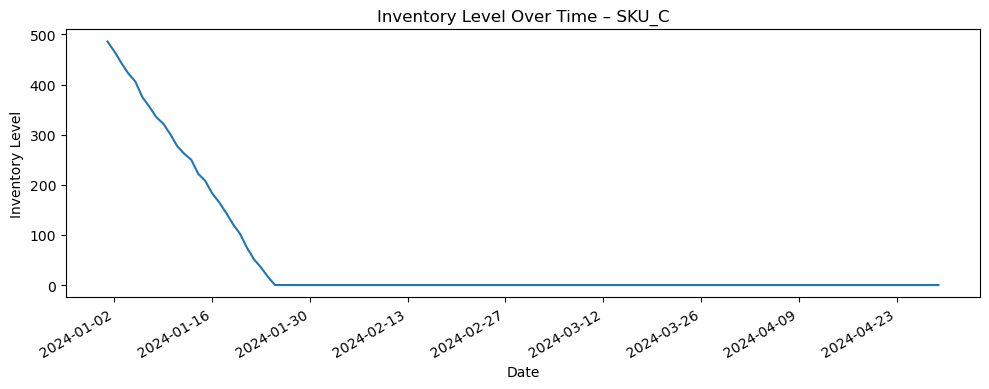

In [11]:
import matplotlib.dates as mdates

# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"])

for sku in df["sku"].unique():
    sku_data = df[df["sku"] == sku]

    plt.figure(figsize=(10, 4))
    plt.plot(sku_data["date"], sku_data["inventory_level"])

    plt.title(f"Inventory Level Over Time – {sku}")
    plt.xlabel("Date")
    plt.ylabel("Inventory Level")

    # Format date axis
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()


# 7. Insights & Recommendations

### Key Insights
- Inventory levels for all SKUs decline rapidly, leading to frequent stockouts.
- High stockout rates indicate that current replenishment policies are insufficient.
- Demand variability differs slightly across SKUs, suggesting different safety stock needs.
- After inventory reaches zero, stock remains depleted for extended periods.

### Recommendations
- Increase safety stock levels for all SKUs, especially those with higher demand variability.
- Recalculate reorder points using historical demand and lead time data.
- Introduce continuous monitoring of stockout rate as a key warehouse KPI.
- Consider more frequent replenishment cycles to improve service levels.